In [1]:
import sys
sys.path.append("../AnchorbasedGraphicalGenome/")
sys.path.append("../../MHC_Graph")
import CCGG_extension as CCGG
import AGG
from Levenshtein import distance as levenshtein_distance
import pandas as pd
import matplotlib.pyplot as plot
import numpy

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
%matplotlib inline
import scipy

In [7]:
def find_all_reads(graph):
    read_sets = set()
    edgelist = graph.edges.keys()
    for item in edgelist:
        readlist = graph.edges[item]['reads']
        for read in readlist:
            read_sets.add(read)
    return read_sets

def construct_table(graph):
    read_sets = find_all_reads(graph)
    read_sets = list(read_sets)
    edgelist = sorted(graph.edges.keys())
    vector_matrix = {}
    for edge in edgelist:
        vector_matrix[edge] = vector_matrix.get(edge, {}) 
        for reads in graph.edges[edge]['reads']:
            vector_matrix[edge][reads] = vector_matrix[edge].get(reads, 0) + 1

    df = pd.DataFrame(vector_matrix).T
    df = df[df.sum(axis = 1)>1]
    df = df.fillna(0)
    return df

In [8]:
def find_clusters(df):
    clusters = []
    scaler = StandardScaler()
    X = scaler.fit_transform(df.T)
    k_opt = 3
    kmeans = KMeans(n_clusters=k_opt, random_state= 48)
    kmeans.fit(X)
    for k in range(k_opt):
        readlist =  sorted([df.columns[i] for i, s in enumerate(kmeans.labels_) if s == k] )
        clusters.append(readlist)
    return clusters

In [38]:
filename = "./HLA-DRB1_raw-seriesparallele.gfa"
filename = "./HLA-DRB1-seriesparallele.gfa"
graph = AGG.GraphicalGenome(filename)
#graph.edges[edge].keys()

In [39]:
df = construct_table(graph)
df

,m64136_200924_175741/102631218/ccs|HG02109,MHC-CHM13,m64136_200924_175741/138740310/ccs|HG02109,m64076_200125_231256/120391020/ccs|HG02257,m54329U_200610_234222/395727/ccs|HG03516,m64043_200716_182902/20384515/ccs|HG00673,m64043_200702_173033/74188716/ccs|HG00735,m64076_200125_231256/75301483/ccs|HG02257,m64043_200618_201934/97519779/ccs|HG01175,m64043_200702_173033/118688393/ccs|HG00735,...,m64136_200612_201033/116132509/ccs|HG01952,m64136_200904_190830/91818047/ccs|HG03492,m64136_200530_164818/147259626/ccs|HG01978,m64043_191210_201113/96471803/ccs|NA21309,m64043_200716_182902/44959615/ccs|HG00673,m64043_200410_214826/1424/ccs|HG02886,m64043_200904_190723/166135399/ccs|HG02080,m64043_191221_024136/137038623/ccs|HG02723,m64043_200625_174853/72090928/ccs|HG01106,m64043_191210_201113/76021868/ccs|NA21309
E03746.0000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E03746.0001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E03746.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E03746.0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E03746.0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E04173.0000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
E04173.0001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
E04173.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
E04173.0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
def mode_of_rows(matrix):
    # Initialize an empty list to store the mode of each row
    modes = []
    
    # Iterate over each row in the matrix
    for row in matrix:
        # Filter out NaN values from the row
        filtered_row = row[~numpy.isnan(row)]
        
        # Check if the filtered row is not empty
        if filtered_row.size > 0:
            # Calculate the mode of the filtered row
            mode_result = stats.mode(filtered_row)
            #print(mode_result)
            # Append the mode value to the modes list
            modes.append(mode_result.mode)
        else:
            # If the row was entirely NaN, append a NaN to the modes list
            modes.append(numpy.nan)
    
    return numpy.array(modes)

In [41]:
# filling NaN values, SVD low-rank decomposition
def svd_impute(matrix, rank, max_iter=100, tol=1e-5):
    """
    Impute missing values using SVD.

    Parameters:
    - matrix: np.array, the matrix with missing values (np.nan) to be imputed
    - max_iter: int, maximum number of iterations
    - tol: float, tolerance for convergence

    Returns:
    - imputed_matrix: np.array, the matrix with missing values imputed
    """
    # Initialize missing values with row means / anchor means
    row_modes = mode_of_rows(matrix)
    inds = numpy.where(numpy.isnan(matrix))
    matrix[inds] = numpy.take(row_modes, inds[0])

    # fill all Nan values with 0s
    # inds = numpy.where(numpy.isnan(matrix))
    # matrix[inds] = 0

    prev_matrix = matrix.copy()
    for _ in range(max_iter):
        # Perform SVD
        U, s, Vt = numpy.linalg.svd(matrix, full_matrices=False)
        s = numpy.diag(s[:rank])
        # Reconstruct the matrix
        matrix_approx = numpy.dot(U[:,:rank], numpy.dot(s, Vt[:rank, :]))

        # Update the matrix with estimated values for missing entries
        matrix[inds] = matrix_approx[inds]

        # Check for convergence (Frobenius norm of the difference between iterations)
        diff = numpy.linalg.norm(matrix - prev_matrix, 'fro')
        if diff < tol:
            break
        prev_matrix = matrix.copy()

    return matrix

In [42]:
def construct_anchor_table(graph, threshold = 0.5):
    read_sets = find_all_reads(graph)
    read_sets = list(read_sets)
    edgelist = sorted(graph.edges.keys())
    vector_matrix = {}
    for edge in edgelist:
        anchor = graph.incoming[edge][0]
        outgoinglist = graph.outgoing[anchor]
        D = dict(zip(sorted(outgoinglist), range(len(outgoinglist))))
        vector_matrix[anchor] = vector_matrix.get(anchor, {}) 
        for reads in graph.edges[edge]['reads']:
            vector_matrix[anchor][reads] = D[edge]

    df = pd.DataFrame(vector_matrix).T
    #columns = df.columns[df.isna().sum(axis = 0)/df.shape[0] < threshold]
    #df = df.loc[:, columns]
    #df = df.fillna(-1)
    return df

In [43]:
df_anchors = construct_anchor_table(graph)

In [44]:
import scipy.stats as stats
def imputation_all(df_anchors, rank):

    M = svd_impute(df_anchors.values, rank)
    df_imputed = pd.DataFrame(M,columns = df_anchors.columns, index = df_anchors.index)

    return df_imputed.round(0)

In [45]:
sample = "HG00621"
rank = 5
df_imputed = imputation_all(df_anchors, rank)

cols = df_imputed.columns
cols = [readname for readname in cols if readname.split("|")[-1] == sample]
df_single_sample = df_imputed.loc[:,cols]
df_single_sample.shape

(35, 5)

In [46]:
# Phase the table
def phase_table(df_single_sample, graph):
    anchorlist = df_single_sample.index
    haplotype1 = []
    haplotype1_readsets = set()
    haplotype2 = []
    haplotype2_readsets = set()

    c = 0
    for anchor in anchorlist:
        current = df_single_sample.loc[anchor,:]
        values, counts = numpy.unique(current,return_counts = True)
        #print(current)
        indexes = numpy.argsort(counts)[::-1]
        values = values[indexes]
        counts = counts[indexes]
        
        readsets1 = list(current[current == values[0]].index)
        if len(values) == 1:
            readsets2 = list(current[current == values[0]].index)
        else:
            readsets2 = list(current[current == values[1]].index)

        if c == 0:
            haplotype1_readsets = readsets1
            haplotype2_readsets = readsets2
            c += 1

        if len(values) == 1:
            edge = sorted(graph.outgoing[anchor])[int(values[0])]
            haplotype1.append((anchor, edge))
            haplotype2.append((anchor, edge))
            haplotype1_readsets = sorted(set(haplotype1_readsets) & set(readsets1))
            haplotype2_readsets = sorted(set(haplotype2_readsets) & set(readsets1))
        else:
            num1 =  len(set(haplotype1_readsets) & set(readsets1))
            num2 = len(set(haplotype1_readsets) & set(readsets2))
            num3 = len(set(haplotype2_readsets) & set(readsets1))
            num4 = len(set(haplotype2_readsets) & set(readsets2))
            #print(num1, num2, num3, num4)
            edge1 = sorted(graph.outgoing[anchor])[int(values[0])]
            edge2 = sorted(graph.outgoing[anchor])[int(values[1])]
            #print(edge1, edge2)
            if num1 > num2 and num4 > num3:
                haplotype1.append((anchor, edge1))
                haplotype2.append((anchor, edge2))
                haplotype1_readsets = sorted(set(haplotype1_readsets) & set(readsets1))
                haplotype2_readsets = sorted(set(haplotype2_readsets) & set(readsets2))

            elif num1 < num2 and num4 < num3:
                haplotype1.append((anchor, edge2))
                haplotype2.append((anchor, edge1))
                haplotype1_readsets = sorted(set(haplotype1_readsets) & set(readsets2))
                haplotype2_readsets = sorted(set(haplotype2_readsets) & set(readsets1))

            else: # controversial events: select the most supported path
                print(anchor, num1, num2, num3, num4)
                haplotype1.append((anchor, edge1))
                haplotype2.append((anchor, edge1))
                haplotype1_readsets = sorted(set(haplotype1_readsets) )
                haplotype2_readsets = sorted(set(haplotype2_readsets))


        
    return haplotype1_readsets, haplotype1, haplotype2_readsets, haplotype2

read1, hap1, read2, hap2 = phase_table(df_single_sample, graph)
read1, read2

A004000 0 0 1 0
A004062 0 0 1 0
A004078 0 0 1 0
A004129 1 0 0 0
A004139 1 0 0 0
A004145 1 0 1 0


(['m64136_200710_174522/49743853/ccs|HG00621'],
 ['m64136_200710_174522/110363982/ccs|HG00621'])

In [47]:
# or output consensus

# consensus, calculate mode of each row
M = df_imputed.values
row_mode = stats.mode(M, axis=1)
df_consensus = pd.DataFrame(row_mode[0], columns = ['consensus'], index=df_imputed.index)
df_consensus

,consensus
A003746,2.0
A003818,2.0
A003821,2.0
A003839,3.0
A003922,3.0
A003943,6.0
A003952,3.0
A003982,0.0
A004000,5.0
A004021,0.0


/Users/suhang/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


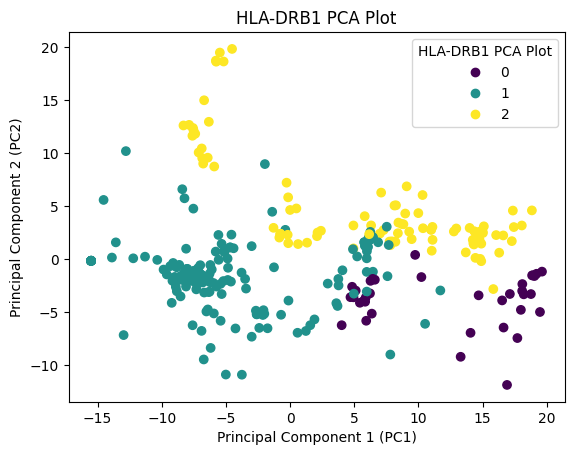

In [49]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_imputed.T)

pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

scaler = StandardScaler()
X = scaler.fit_transform(df_imputed.T)
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state= 48)
kmeans.fit(X)

# Plot the PCA plot
genename = "HLA-DRB1"
scatter = plot.scatter(pc_df['PC1'], pc_df['PC2'],c=kmeans.labels_.astype(float) )
plot.title('%s PCA Plot' % genename)
plot.xlabel('Principal Component 1 (PC1)')
plot.ylabel('Principal Component 2 (PC2)')
plot.legend(*scatter.legend_elements(), title="%s PCA Plot" % genename)
plot.show()

In [ ]:
# find the clusters in the edge presence absence table 
# do imputation from subset of reads from the table

def imputation(df_edge, df_anchors, rank):
    df_edge = df_edge.loc[:, df_anchors.columns]
    clusters = find_clusters(df_edge)
    df_imputed = pd.DataFrame([])
    for c in clusters:
        d = df_anchors[c]
        M = svd_impute(d.values, rank)
        d_imputed = pd.DataFrame(M,columns = d.columns, index = d.index)
        df_imputed= pd.concat([df_imputed, d_imputed], axis = 1)
        # print(d_imputed.shape, df_imputed.shape)
    return df_imputed.round(0)